# My D2Q9 implementation for a simple Poiselle Flow

The objective of this exploration is to develop a single phase D2Q9 implementation of LB to replicate Poiselle flow. This will involve a pressure source on the left boundary of the system, no-slip boundaries on the top and b ottom and periodic boundaries on the right side of the system. The goals of this project will be to develop a module that can be uploaded to nanohub to allow others to learn about LBM. 

Objectives to be met are
1. Develop a working LB implementation
    1. First, flow through a channel without poiselle flow and periodic boundary conditions
2. Implement boundary conditions
    1. Implementation of (1) with the boundary conditions stated above
3. Implement the arbitary boundaries that users can place


## D2Q9 lattice

Lattice Boltzmann is derived from a discretization of the Boltzmann equation to reduce the computational load that simulating every particle would take. To ensure appropriate momentum transfer, lattice directions are implemented to allow for exchange of mass, momentum and energy between particles in a different lattice. Many lattices exist such as teh D1Q3, D1Q5, D2Q7, D3Q15, D3Q19 and D3Q27. This exercise will focus on the D2Q9 lattice. (insert picture here)

### Governing equation

$$f_{i}(x + c_i \Delta x, t + \Delta t) = f_{i}(x, t) + \Omega_{i}(x, t)$$

Lattice Boltzmann operates in two stages. The first is the collision step, followed by the streaming step. The collision step represents the change in particle densities in each direction on each site while the streaming step moves particles between lattice directions. The equation above represents the generalized equation for lattice boltzmann's collision step. $f$ represents the densities of particles at lattice node $x$ in lattice direction $c_i$ a time $t$. $\Omega$ represents the collision operator. There are many schemes to determine the collision operator but in this work, the Bhatnagar Gross and Krook collision operator will be used. This is defined as, 

$$\Omega_{i} = \frac{f_{i}^{eq} - f_{i}}{\tau}$$

Where $f_{eq}$ represents the equilibrium distribution of particles at $\rho$, the density of particles, and $u$, the velocity of particles, of the lattice point.

The macroscopic density is defined as, 

$$ \rho = \rho_{0} \sum_{i} f_{i}$$

The macroscopic velocity is defined as, 

$$ u = \frac{\sum_{i} f_{i} c_i}{\rho}$$

## Boundary Conditions

Boundary conditions are essential in any transport problem as they control the flow of the property of interest. In Lattice Boltzmann, the boundary conditions available allow for the replication of Dirichlet, Neumann, Robin, Mixed, Cauchy and periodic boundary conditions. In this example, a simple Dirichlet boundary condition will be imposed on the top and bottom walls to simulate a no-slip boundary. A periodic boundary will be imposed on the right wall. A Cauchy boundary will be implemented on the left wall to simulate a pressure gradient. 

### Bounce Back BC

There are two types of bounce back boundary conditions. One is the fullway bounceback boundary and the other is a half-way bounceback. The difference between both is when the inversion of particle velocities occur. The fullway bounceback boundary reflection occurs in the collision step of the next timestep while the halfway bounceback boundary reflection occurs during the streaming step of the same timestep. This boundary condition is mass conserving. 

## Reynolds number

$$ Re = \frac{\rho v R_{h}}{\eta} $$

The above defines the reynolds number of the system where $\rho$ is the total density of the system, $v$ is the velocity of the flow, $R_{h}$ is the hydraulic radius of the body defined as $R_{h} = \frac{A}{L}$ and $\eta$ is the dynamic viscosity. The above expression can be further simplified to be,

$$ Re = \frac{v R_{h}}{\nu} $$

where $\nu$ is the kinematic viscosity of the system defined as $\nu = \frac{\eta}{\rho}$

In Lattice Boltzmann, the kinematic viscosity is defined as, 

$$\nu = c_{s}^{2}(\tau - \frac{1}{2})$$

Where $\tau$ is the relaxation time of the system usually set at 1. 

The hydraulic radius for our channel is defined as, the width of the channel and is obtained from the formula for the hydraulic radius shown above. 

Therefore, for this system, the Reynolds number can be re-written to find the velocity and is shown to be, 

$$Re = \frac{R_{h} v }{c_{s}^{2}(\tau - \frac{1}{2})}$$

For example, for $Re = 1$, $\tau = 1$, $c_s = \frac{1}{\sqrt{3}}$ and $R_{h} = 100$, $v = 0.0017$

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import animation
from IPython.display import HTML
from PIL import Image, ImageDraw
import pyevtk.hl 
import os

from src import lb_helper, animations, boundaries, data_IO, objects

# %matplotlib notebook
# %matplotlib inline

In [2]:
nx = 400   # resolution x-dir
ny = 100   # resolution y-dir
rho0 = 1   # density 
tau = 1.0    # collision timescale
n_iteration = 5   # number of timesteps
Re = 10

bounce_back_walls = ['top', 'bottom']

wall_placement = ['top']
wall_v = {'top':0.0}

halo_extent = 1

pressure = False
Pin = 1
Pout = 0

0.016666666666666673


NameError: name 'tau' is not defined

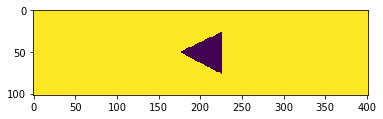

In [3]:
Ny = ny + 2*halo_extent
Nx = nx + 2*halo_extent
cs = 1/np.sqrt(3)
nu = (cs**2)*(tau - 0.5)
v = (Re*nu)/(ny)

rho_in = Pin/cs**2
rho_out = Pout/cs**2

idxs_grid = np.array([[8, 1, 2], [7, 0, 3], [6, 5, 4]])

NL = 9
idxs = np.arange(NL)
vx_s = np.array([0, 0, 1, 1, 1, 0,-1,-1,-1])
vy_s = np.array([0, 1, 1, 0,-1,-1,-1, 0, 1])
weights = np.array([4/9,1/9,1/36,1/9,1/36,1/9,1/36,1/9,1/36]) # sums to 1
X, Y = np.meshgrid(range(Nx), range(Ny))

F = np.ones((Ny,Nx,NL)) #+ 0.01*np.random.randn(Ny,Nx,NL)
F[:,:,3] += v #2 * (1+0.2*np.cos(2*np.pi*X/Nx*4))
print(v)

u_w = np.zeros((Ny, Nx, 2))
# u_w = assign_wall_velocity(u_w, wall_v, wall_placement)

grid = np.zeros((Ny, Nx))
grid += 10
i = 0
grid, tri1 = objects.place_triangle(grid, Nx//2, Ny//2, 50, 50, fill = i, angle = 270)
boundaries = np.array([tri1])
plt.imshow(grid)

if pressure == True:
    F = lb_helper.pressure_gradient(F, rho_in, rho_out)

rho, u , v = lb_helper.macroscopic(F)
for i in idxs:
    F[:,:,i] *= rho0 / rho

t_s, rho_s, u_s, v_s = lb_helper.time_loop(F, n_iteration, boundaries, bounce_back_walls)

bound = Re/2500

In [ ]:
np.sum(rho_s[:, 1:-1, 1:-1], axis = (1, 2))

In [ ]:
ani = cmap_ani(rho_s[:, 1:-1, 1:-1])
HTML(ani.to_jshtml())
# rho_s[:, 1:-1, 1:-1].shape

In [ ]:
ani = cmap_ani(u_s[:, 1:-1, 1:-1])
HTML(ani.to_jshtml())

In [ ]:
ani = cmap_ani(v_s[:, 1:-1, 1:-1])
HTML(ani.to_jshtml())

In [ ]:
# #https://holypython.com/how-to-save-matplotlib-animations-the-ultimate-guide/

# ani = plot_images_2D(rho_s)
# f = r'/home/nkarthi/Reports/24_1_2022_presentation/D2Q9/ani_couette.gif'
# writergif = animation.PillowWriter(fps=30) 
# ani.save(f, writer=writergif)
# # HTML(ani)

In [283]:
import numpy as np
from src import lb_helper, animations


class LBFluid:
    def __init__(self, box, rho0, tau):
        # Lattice definition
        self.idxs_grid = np.array([[6, 2, 5], [3, 0, 1], [7, 4, 8]])
        self.NL = self.idxs_grid.size
        self.idxs = np.arange(self.NL)

        self.vx_s = np.array([0, 1, 0, -1, 0, 1, -1, -1, 1])
        self.vy_s = np.array([0, 0, 1, 0, -1, 1, 1, -1, -1])
        self.weights = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
        self.halo = 1
        
        # System definitions
        self.nx = box[0]
        self.ny = box[1]
        
        self.rho = rho0
        self.tau = tau
        self.omega = 1/tau
        self.Pin = 0
        self.Pout = 0
        
        self.cs = 1/np.sqrt(3)
        self.nu = (self.cs**2)*(self.tau - 0.5)
        
        self.f = None
        self.f_star = None
        self.f_eq = None
        self.define_domain()
        self.walls = None
        self.periodic = None
                                  
    def define_domain(self):
        u = np.zeros((self.ny + self.halo*2, self.nx + self.halo*2)),
        v = np.zeros_like(u)
        
        self.f = self.equilibrium(rho = self.rho, u = u, v = v)
        self.f_star = np.zeros_like(self.f)
        self.f_eq = np.zeros_like(self.f)
            
        rho, u , v, sigma_ab = self.macroscopic()
        self.f_eq = self.equilibrium(rho, u, v)
        self.f_star = (1 - self.omega)*self.f + self.omega*self.f_eq
        
    def periodic_boundaries(self, wall):
        self.periodic = []
        if type(wall) == str:
            self.periodic.append(wall)
        else:
            for i in wall:
                self.periodic.append(i)
                
    def wall_boundaries(self, wall):
        self.walls = []
        if type(wall) == str:
            self.walls.append(wall)
        else:
            for i in wall:
                self.walls.append(i)
        
    def integrate(self, steps, output_steps = 1):
        output_iter = steps//output_steps
        rho_s = np.zeros((output_iter, self.ny, self.nx))
        u_s = np.zeros((output_iter, self.ny, self.nx))
        v_s = np.zeros((output_iter, self.ny, self.nx))
        sigma_s = np.zeros((output_iter, 2, 2, self.ny, self.nx))
        
        for t in range(steps):
            # print(t)
            rho, u, v, sigma_ab = self.time_loop() 
            # print(rho.shape, u.shape, v.shape, sigma_ab.shape)
            if t%output_steps == 0:
                # print(t%output_steps, t)
                i = t//output_steps
                rho_s[i] = rho
                u_s[i] = u
                v_s[i] = v
                sigma_s[i] = sigma_ab
        return rho_s, u_s, v_s, sigma_s

    def time_loop(self):
        h = self.halo
        
        # Perform streaming/propagation step
        self.streaming()  
        
        #Boundary condition
        self.bounce_back()
        
        # Periodic BC and pressure 
        self.periodic_BC()
        self.pressure_condition()
        
        # Moment update
        rho, u , v, sigma_ab = self.macroscopic()
        
        # Compute equilibrium distribution
        self.f_eq = self.equilibrium(rho, u, v)
        
        # Perform collision step
        self.f_star = (1 - self.omega)*self.f + self.omega*self.f_eq
        
        return rho[h:-h, h:-h], u[h:-h, h:-h], v[h:-h, h:-h], sigma_ab[..., h:-h, h:-h]
        
    def macroscopic(self):
        rho = self.rho * np.sum(self.f, axis = -1)
        u = np.sum(self.f*self.vx_s, axis = -1)/rho
        v = np.sum(self.f*self.vy_s, axis = -1)/rho
        P_xx = np.sum(self.vx_s*self.vx_s * (self.f - self.f_eq), axis = -1)
        P_xy = np.sum(self.vx_s*self.vx_s * (self.f - self.f_eq), axis = -1)
        P_yx = P_xy
        P_yy = np.sum(self.vy_s*self.vy_s * (self.f - self.f_eq), axis = -1)
        sigma_ab = np.array([[P_xx, P_xy], [P_yx, P_yy]])
        return rho, u, v, sigma_ab

    def equilibrium(self, rho, u, v):
        f_eq = np.zeros((*u.shape, self.NL))
        usqr = (u**2 + v**2)/(2*(self.cs**2))
        for i in range(self.NL):
            cu = self.vx_s[i]*u + self.vy_s[i]*v
            f_eq[..., i] = self.weights[i]*rho*(1 + cu/(self.cs**2) + cu**2/(2*(self.cs**4)) - usqr)
        return f_eq

    def streaming(self):
        h = self.halo
        for i, vx, vy in zip(np.arange(self.NL), self.vx_s, self.vy_s):
            self.f[:, :, i] = np.roll(self.f_star[:, :, i], vx, axis = 1)
            self.f[:, :, i] = np.roll(self.f_star[:, :, i], vy, axis = 0)
            # self.f[h:-h, h:-h, i] = np.roll(self.f_star[h:-h, h:-h, i], vx, axis = 1)
            # self.f[h:-h, h:-h, i] = np.roll(self.f_star[h:-h, h:-h, i], vy, axis = 0)
            
    def bounce_back(self):
        if self.walls != None:
            for side in self.walls:
                if 'top' in side:
                    self.f[-2, :, self.idxs_grid[2]] = self.f_star[-2, :, self.idxs_grid[0]]
                elif 'bottom' in side:
                    self.f[1, : , self.idxs_grid[0]] = self.f_star[1, :, self.idxs_grid[2]]
                elif 'left' in side:
                    self.f[:, 1, self.idxs_grid[:, 0]] = self.f_star[:, 1, self.idxs_grid[:, 2]]
                elif 'right' in side:
                    self.f[:, -2, self.idxs_grid[:, 2]] = self.f_star[:, -2, self.idxs_grid[:, 0]]
                else:
                    print('wall location not recognized')
    
    def periodic_BC(self):
        if self.periodic != None:
            for side in self.periodic:
                if 'top' in side:
                    # self.f_star[-1, :, self.idxs_grid[2]] = self.f_star[1, :, self.idxs_grid[2]]
                    self.f_star[0, :, self.idxs_grid[2]] = self.f_star[-2, :, self.idxs_grid[2]]
                elif 'bottom' in side:
                    # self.f_star[0, :, self.idxs_grid[0]] = self.f_star[-2, :, self.idxs_grid[0]]
                    self.f_star[-1, :, self.idxs_grid[0]] = self.f_star[1, :, self.idxs_grid[0]]
                elif 'left' in side:
                    self.f_star[:, -1, self.idxs_grid[:, 0]] = self.f_star[:, 1, self.idxs_grid[:, 0]]
                elif 'right' in side:
                    self.f_star[:, 0, self.idxs_grid[:, 2]] = self.f_star[:, -2, self.idxs_grid[:, 2]]
         
    def EoS_rho(self, p):
        return p/(self.cs**2)

    def EoS_p(self, rho):
        return (self.cs**2)*rho
        
    def pressure_condition(self):
        # left to right pressure gradient
        rho, u, v, sigma_ab = self.macroscopic()
        rho_in = self.EoS_rho(self.Pin)
        rho_out = self.EoS_rho(self.Pout)
        
        f_eq_in = self.equilibrium(rho_in, u[:, -2], v[:, -2])
        f_eq_out = self.equilibrium(rho_out, u[:, 1], v[:, 1])
        
        self.f_star[:, 0, :] = f_eq_in + self.f_star[:, -2, :] - self.f_eq[:, -2, :]
        self.f_star[:, -1, :] = f_eq_out + self.f_star[:, 1, :] - self.f_eq[:, 1, :]

SyntaxError: positional argument follows keyword argument (505898159.py, line 41)

In [281]:
# u_w = np.zeros((Ny, Nx, NL, 2))
# np.unique(u_w).size
%time
nx = 400
ny = 100
lbf =  LBFluid(box = [nx, ny], rho0 = 1, tau = 1)
lbf.Pin = 0.0001
lbf.wall_boundaries(['top', 'bottom'])
lbf.periodic_boundaries(['left', 'right'])

a = lbf.integrate(steps = 100)
# %time

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


In [282]:
np.sum(a[0], axis = (1, 2))/(nx*ny)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [276]:
# dir(animations)

ani = animations.cmap_ani(a[1])

HTML(ani.to_jshtml())

# a[-1][:][0][0][0].shape

In [157]:
rho_s = a[0]
np.unique(rho_s[0] == rho_s[-1])

array([ True])

In [113]:
a = np.random.randint(0, 5, (10, 50))
# b = np.random.randint(0, 5, (5, 5))

# a[0] = a[:, 0] - b[:, 0] + b[0]

a[0].size

50

In [ ]:
# from PIL import Image, ImageDraw, ImageFont

# im = Image.new("RGB", (512, 512), (128, 128, 128))
# draw = ImageDraw.Draw(im)
# # draw.line((0, im.height, im.width, 0), fill=(255, 0, 0), width=8)
# draw.rectangle((100, 100, 200, 200), fill=(0, 255, 0))
# draw.ellipse((250, 300, 450, 400), fill=(0, 0, 255))
# # font = ImageFont.truetype('/Library/Fonts/Arial Bold.ttf', 48)
# draw.multiline_text((0, 0), 'Pillow sample', fill=(0, 0, 0))
# im

In [76]:
X, Y = np.meshgrid(range(5), range(5))
X, Y
1+0.2*np.cos(2*np.pi*X/5*4)

array([[1.2      , 1.0618034, 0.8381966, 0.8381966, 1.0618034],
       [1.2      , 1.0618034, 0.8381966, 0.8381966, 1.0618034],
       [1.2      , 1.0618034, 0.8381966, 0.8381966, 1.0618034],
       [1.2      , 1.0618034, 0.8381966, 0.8381966, 1.0618034],
       [1.2      , 1.0618034, 0.8381966, 0.8381966, 1.0618034]])

In [ ]:
rhos = np.array(rhos)
ani = plot_images_2D(rhos)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Python Imaging Library imports
from PIL import Image, ImageDraw, ImageFont

def place_rect(x, y, width, height, angle):
    rect = np.array([(0, 0), (width, 0), (width, height), (0, height), (0, 0)])
    theta = (np.pi / 180.0) * angle
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    offset = np.array([x, y])
    transformed_rect = np.dot(rect, R) + offset
    return transformed_rect

rect = get_rect(x=120, y=80, width=100, height=40, angle=30.0)
rect

grid = np.random.randint(low = 0, high = 256, size = (400, 400))

img = Image.fromarray(grid.astype(np.uint8))
draw = ImageDraw.Draw(img)
draw.polygon([tuple(p) for p in rect], fill=0)
new_data = np.asarray(img)
plt.imshow(new_data, cmap=plt.cm.gray)
plt.show()

x, y = np.where(new_data == 0)

print(np.unique(new_data[x, y]))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Python Imaging Library imports
from PIL import Image, ImageDraw, ImageFont

def rotate(vertices, theta):
    theta = (theta/180)*np.pi
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    return np.dot(vertices, R)
  
def place_object(grid, obj, f):
    img = Image.fromarray(grid.astype(np.uint8))
    draw = ImageDraw.Draw(img)
    draw.polygon([tuple(p) for p in obj], fill=f)
    new_data = np.asarray(img)
    return new_data, np.where(new_data == f, True, False)        

def place_rect(rho, x, y, width, height, fill = 0, angle = 0):
    rect = np.array([(-width/2, -height/2), (width/2, -height/2), (width/2, height/2), (-width/2, height/2)])
    offset = np.array([x, y])
    transformed_rect = rotate(rect, angle) + offset
    rho, obj = place_object(rho, transformed_rect, fill)
    return rho, obj

def place_triangle(rho, x, y, width, height, fill = 0, angle = 0):
    triangle = np.array([(width/2, -height/2), (-width/2, -height/2), (0, height/2)])
    offset = np.array([x, y])
    transformed_triangle = rotate(triangle, angle) + offset
    rho, obj = place_object(rho, transformed_triangle, fill)
    return rho, obj

def place_ellipse(rho, x, y, r1, r2, fill = 0):
    ell = [(x - r1, y - r2), (x + r1, y + r2)]
    img = Image.fromarray(rho.astype(np.uint8))
    draw = ImageDraw.Draw(img)
    draw.ellipse(ell, fill = fill)
    new_data = np.asarray(img)
    return new_data, np.where(new_data == fill, True, False)

grid = np.random.randint(low = 2, high = 256, size = (300, 300))

# grid, rect1 = place_rect(grid, 50, 50, 50, 75, 10)
# grid, rect2 = place_rect(grid, 150, 150, 50, 75, 145)
grid, tri1 = place_triangle(grid, 50, 50, 30, 50, fill = 0)
grid, ell1 = place_ellipse(grid, 150, 150, 30, 50, fill = 1)

print(np.unique(ell1))

plt.imshow(grid)
plt.show()

In [ ]:
X, Y = np.meshgrid(range(Ny), range(Nx))
F = np.ones((Ny,Nx,NL)) + 0.01*np.random.randn(Ny,Nx,NL)
# F[:,:,3] += 2 * (1+0.2*np.cos(2*np.pi*X/Nx*4))
print(F.shape)

grid = np.ones((Ny, Nx))
grid += 3
print(grid.shape)
grid, rec = place_rect(grid, 200, 50, 25, 25, fill = 0)
print(grid.shape, rec.shape)
grid, tri = place_triangle(grid, 50, 50, 25, 70, fill = 1, angle = 270)
print(grid.shape, tri.shape)
plt.imshow(grid)
print(F[tri, :].shape)

In [ ]:
# https://github.com/python-pillow/Pillow/issues/2204